In [45]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import tensorly.kruskal_tensor as tl_kruskal
import tensorly.random as tl_rand
import numpy as np
import statistics
from timeit import default_timer as timer

from cpd_mwu import CPD_MWU

In [48]:
norm_time = []
id_time = []
uf_time = []
w_time = []
rand_time = []

sketching_rates = list(np.linspace(10**(-3), 10**(-1), 4)) + [1]

for i in range(100):
    # Generate random latent factors
    F = np.array(tl_rand.random_kruskal(shape=shape, rank=rank, full=False, random_state=np.random.RandomState(seed=i)))
    X = tl_kruskal.kruskal_to_tensor(F)

    # Time norm
    start = timer()
    norm_x = norm(X)
    end = timer()
    norm_time.append(end-start)

    # Time ID
    start = timer()
    y = np.eye(rank)
    end = timer()
    id_time.append(end-start)

    # Time unfolding
    start = timer()
    X_unfold = [unfold(X, mode=0), unfold(X, mode=1), unfold(X, mode=2)]
    end = timer()
    uf_time.append(end-start)

    # Time initialization of weights
    start = timer()
    weights = np.array([1] * len(sketching_rates)) / (len(sketching_rates))
    end = timer()
    w_time.append(end - start)

    # Time random initialization of factor matrices
    start = timer()
    dim_1, dim_2, dim_3 = X.shape
    A, B, C = rand_init(dim_1, rank), rand_init(dim_2, rank), rand_init(dim_3, rank)   
    end = timer()
    rand_time.append(end - start)
    
    
    
mean_norm = statistics.mean(norm_time)
var_norm = statistics.variance(norm_time)

mean_id = statistics.mean(id_time)
var_id = statistics.variance(id_time)

mean_uf = statistics.mean(uf_time)
var_uf = statistics.variance(uf_time)

mean_w = statistics.mean(w_time)
var_w = statistics.variance(w_time)

mean_rand = statistics.mean(rand_time)
var_rand = statistics.variance(rand_time)

[0.007991203190285887, 2.4966420060081873e-05, 0.13720415555955698, 4.426566003530752e-05, 7.220168990897946e-05]
0.14533679251984724


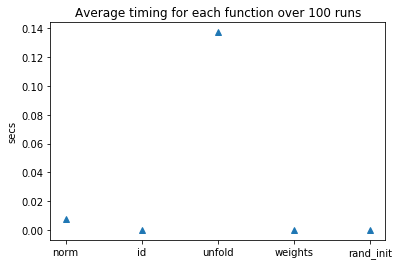

In [49]:
x = ['norm', 'id', 'unfold', 'weights', 'rand_init']
y = [mean_norm, mean_id, mean_uf, mean_w, mean_rand]
var = [var_norm, var_id, var_uf, var_w, var_rand]
plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')

print(y)
print(sum(y))

In [55]:
from helper import generate_sketch_indices
import tensorly.tenalg as tl_alg
from numpy.linalg import pinv, norm

F = np.array(tl_rand.random_kruskal(shape=shape, rank=rank, full=False, random_state=np.random.RandomState(seed=i)))
X = tl_kruskal.kruskal_to_tensor(F)
X_unfold = [unfold(X, mode=0), unfold(X, mode=1), unfold(X, mode=2)]
Id = np.eye(rank)

# Set up
lamb = 0.001
shape = (300,300,300)
nu = 2
rank = 5  
num_iterations = 100

A_sketch_time = []
AM_time = []
A_time = []

B_sketch_time = []
BM_time = []
B_time = []

C_sketch_time = []
CM_time = []
C_time = []

for i in range(100):
    s = sample(sketching_rates, weights)
    # Update A
    start = timer()
    dim_1, dim_2 = X_unfold[0].shape
    idx = generate_sketch_indices(s, dim_2)
    end = timer()
    A_sketch_time.append(end-start)

    start = timer()
    M = (tl_alg.khatri_rao([A, B, C], skip_matrix=0).T)[:, idx]
    end = timer()
    AM_time.append(end-start)

    start = timer()
    A = (lamb * A + X_unfold[0][:, idx] @ M.T) @ pinv(M @ M.T + lamb * Id)
    end = timer()
    A_time.append(end-start)

    # Update B
    start = timer()
    dim_1, dim_2 = X_unfold[1].shape
    idx = generate_sketch_indices(s, dim_2)
    end = timer()
    B_sketch_time.append(end-start)

    start = timer()
    M = (tl_alg.khatri_rao([A, B, C], skip_matrix=1).T)[:, idx]
    end = timer()
    BM_time.append(end-start)

    start = timer()
    B = (lamb * B + X_unfold[1][:, idx] @ M.T) @ pinv(M @ M.T + lamb * Id)
    end = timer()
    B_time.append(end-start)

    # Update C
    start = timer()
    dim_1, dim_2 = X_unfold[2].shape
    idx = generate_sketch_indices(s, dim_2)
    end = timer()
    C_sketch_time.append(end-start)

    start = timer()
    M = (tl_alg.khatri_rao([A, B, C], skip_matrix=2).T)[:, idx]
    end = timer()
    CM_time.append(end-start)

    start = timer()
    C = (lamb * C + X_unfold[2][:, idx] @ M.T) @ pinv(M @ M.T + lamb * Id)
    end = timer()
    C_time.append(end-start)


# Compute for A  
mean_A_sketch = statistics.mean(A_sketch_time)
var_A_sketch = statistics.variance(A_sketch_time)

mean_AM = statistics.mean(AM_time)
var_AM = statistics.variance(AM_time)

mean_A = statistics.mean(A_time)
var_A = statistics.variance(A_time)

# Compute for B  
mean_B_sketch = statistics.mean(B_sketch_time)
var_B_sketch = statistics.variance(B_sketch_time)

mean_BM = statistics.mean(BM_time)
var_BM = statistics.variance(BM_time)

mean_B = statistics.mean(B_time)
var_B = statistics.variance(B_time)

# Compute for C  
mean_C_sketch = statistics.mean(C_sketch_time)
var_C_sketch = statistics.variance(C_sketch_time)

mean_CM = statistics.mean(CM_time)
var_CM = statistics.variance(CM_time)

mean_C = statistics.mean(C_time)
var_C = statistics.variance(C_time)

[0.01645012235996546, 0.0035781593399224223, 0.07974509716015746]
0.09977337886004534
[0.016170176300111052, 0.0037061691299822997, 0.0797781404500347]
0.09965448588012805
[0.016419847050347016, 0.0037605147700378438, 0.03601114247001533]
0.056191504290400186


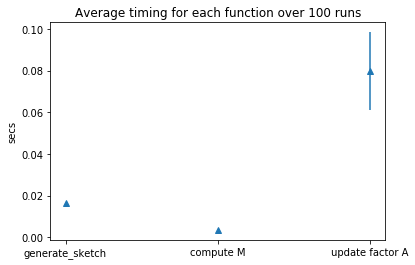

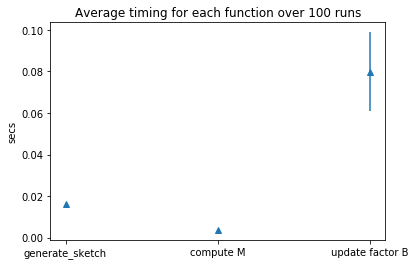

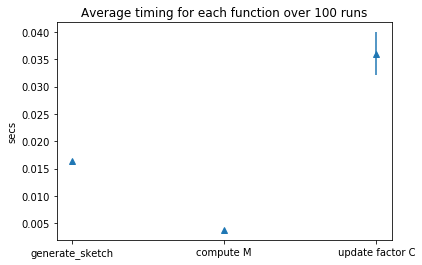

<Figure size 432x288 with 0 Axes>

In [58]:
x = ['generate_sketch', 'compute M', 'update factor A']
y = [mean_A_sketch, mean_AM, mean_A]
var = [var_A_sketch, var_AM, var_A]

plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')
plt.figure()

print(y)
print(sum(y))

x = ['generate_sketch', 'compute M', 'update factor B']
y = [mean_B_sketch, mean_BM, mean_B]
var = [var_B_sketch, var_BM, var_B]

plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')
plt.figure()

print(y)
print(sum(y))

x = ['generate_sketch', 'compute M', 'update factor C']
y = [mean_C_sketch, mean_CM, mean_C]
var = [var_C_sketch, var_CM, var_C]

plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')
plt.figure()

print(y)
print(sum(y))

In [80]:
k_time = []
sub_time = []
norm_time = []

import tensorly.base as tl_base

for i in range(100):
    F = np.array(tl_rand.random_kruskal(shape=shape, rank=rank, full=False, random_state=np.random.RandomState(seed=0)))
    X = tl_kruskal.kruskal_to_tensor(F)
    X_unfold = [tl_base.unfold(X, mode=0)]
    
    start = timer()
    X_bar = A @ (tl_alg.khatri_rao([A, B, C], skip_matrix=0).T)
    end = timer()
    k_time.append(end-start)

    start = timer()
    s = X_unfold[0]-X_bar
    end = timer()
    sub_time.append(end-start)

    start = timer()
    norm(s)/norm_x
    end= timer()
    norm_time.append(end-start)
    
mean_k = statistics.mean(k_time)
var_k = statistics.variance(k_time)

mean_sub = statistics.mean(sub_time)
var_sub = statistics.variance(sub_time)

mean_norm = statistics.mean(norm_time)
var_norm = statistics.variance(norm_time)

[0.10595275194973511, 0.0757129531600367, 0.00818801943991275]
0.18985372454968458


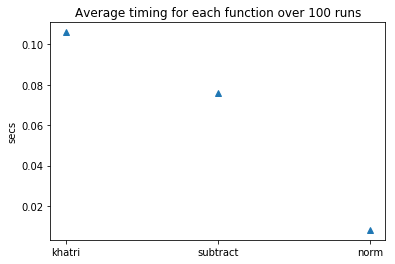

<Figure size 432x288 with 0 Axes>

In [81]:
x = ['khatri', 'subtract', 'norm']
y = [mean_k, mean_sub, mean_norm]
var = [var_k, var_sub, var_norm]

plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')
plt.figure()

In [89]:
from helper import residual_error
import time
t = []

# Initialize weights
weights = np.array([1] * len(sketching_rates)) / (len(sketching_rates))

# Generate random latent factors
F = np.array(tl_rand.random_kruskal(shape=shape, rank=rank, full=False, random_state=np.random.RandomState(seed=0)))
X = tl_kruskal.kruskal_to_tensor(F)
X_unfold = [tl_base.unfold(X, mode=0), tl_base.unfold(X, mode=1), tl_base.unfold(X, mode=2) ]

for i in range(100):
    star = time.time()
    # Randomly initialize A,B,C
    dim_1, dim_2, dim_3 = X.shape
    A, B, C = rand_init(dim_1, rank), rand_init(dim_2, rank), rand_init(dim_3, rank)
    for i, w in enumerate(weights):
        start = time.time()
        s = sketching_rates[i]
        A_new, B_new, C_new = update_factors(A, B, C, X_unfold, Id, lamb, s, rank)
        total_time = time.time() - start
        weights[i] *= np.exp(-nu/eps*(residual_error(X_unfold[0], norm_x, A_new, B_new, C_new) - residual_error(X_unfold[0], norm_x, A, B, C)) / (total_time))

    weights /= sum(weights)
    en = time.time()

    t.append(en-star)
    
mean_t = statistics.mean(t)
var_t = statistics.variance(t)

C:\Users\kkim154\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [90]:
print(mean_t)
print(var_t)

3.3817786741256715
0.014038886226079707
